In [1]:
"""nbconvert header

We are just configuring to hide some unnecessary warnings.
"""
%matplotlib inline
import arpes.config

arpes.config.DOCS_BUILD = True

Activating auto-logging. Current session state plus future input saved.
Filename       : logs/basic-data-exploration_2024-06-03_15-51-41.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


# Basic Data Exploration

In [2]:
import arpes.config
from arpes.io import example_data

f = example_data.cut

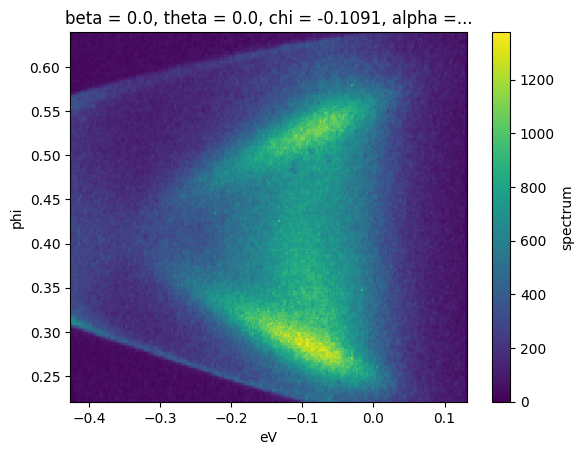

In [3]:
f.S.plot()

Although we can plot the spectrum off of a `Dataset`, which might contain additional attributes like the photocurrent, beam current, temperature, or wall-clock time, by using `.S.plot()`, we can also get the spectrum attribute from the full data:

In [4]:
f.spectrum

<xarray.DataArray 'spectrum' (phi: 240, eV: 240)> Size: 461kB
array([[  1,   2,   0, ..., 110,  76,  61],
       [  0,   1,   0, ...,  79,  74,  42],
       [  1,   0,   0, ...,  65,  65,  41],
       ...,
       [  0,  11,  35, ...,  54,  77,  53],
       [  0,   5,  26, ...,  60,  76,  48],
       [  1,   2,  25, ...,  74,  72,  42]])
Coordinates:
  * eV       (eV) float64 2kB -0.4256 -0.4233 -0.4209 ... 0.1256 0.1279 0.1302
  * phi      (phi) float64 2kB 0.2217 0.2234 0.2251 ... 0.6353 0.637 0.6388
    beta     float64 8B 0.0
    theta    float64 8B 0.0
    chi      float64 8B -0.1091
    alpha    int64 8B 0
    hv       float64 8B 5.93
    z        float64 8B -3.4e-05
    x        float64 8B -0.7704
    psi      int64 8B 0
    y        float64 8B 34.75
Attributes: (12/98)
    file:                      /Users/arafune/src/arpes/src/arpes/example_dat...
    location:                  ALG-MC
    BITPIX:                    8
    NAXIS:                     0
    START_T:                   2/3/2016 1:45:34 PM
    START_TS:                  3537380734.727
    ...                        ...
    perpendicular_deflectors:  False
    analyzer_radius:           150
    analyzer_type:             hemispherical
    mcp_voltage:               nan
    probe_linewidth:           0.015
    chi_offset:                -0.10909301748228785

## Selecting Data

Typically, we will not want to use the full spectrometer window. Instead we will want to focus on a particular energy or momentum range, such as the region just above, below, or around the chemical potential, or at the energy distribution curves (EDCs) around a particular significant momentum. Data selections can be performed either on `Dataset`s or `DataArray`s. In the former case, it has the effect of selecting on a particular dimension or set of dimensions for each attribute that has those dimensions.

In general, we do not need to know the indices of the region we want to select: we can use the physically meaningful coordinates. As an example, to get the band structure from our data `f` between the ground reference of the spectrometer (the chemical potential) and a point 200 millivolts below, we can use `.sel`.

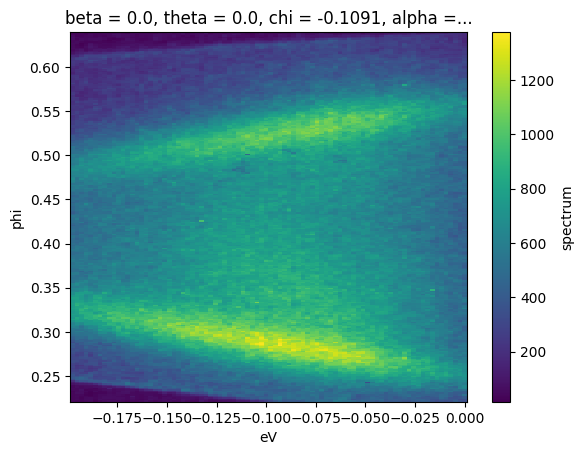

In [5]:
f.sel(eV=slice(-0.2, 0)).S.plot()

`.sel` accepts any number of dimensions specified by a `slice`. The arguments to the slice provide a low and high cutoff respectively.

We can also select just a single point along an axis by passing a value instead of a slice. In general we will want to be safe and pass the `method='nearest'` argument, in order to ensure that if the exact value we requested is not included, we will get the nearest pixel.

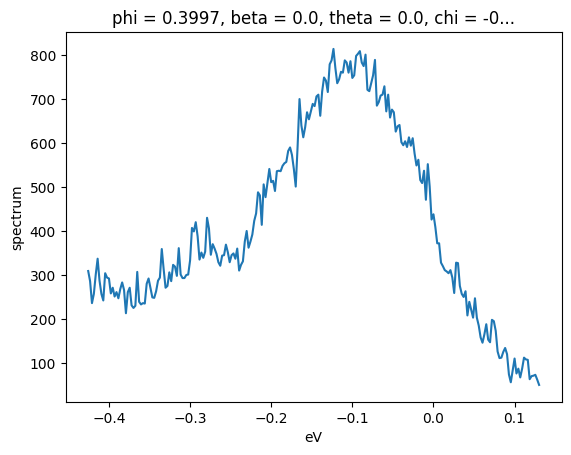

In [6]:
# get the EDC nearly at the gamma point
f.sel(phi=0.4, method="nearest").S.plot()

Of course, we can select over a wider window for better statistics, so long as we average or sum out the angle axis after selecting.

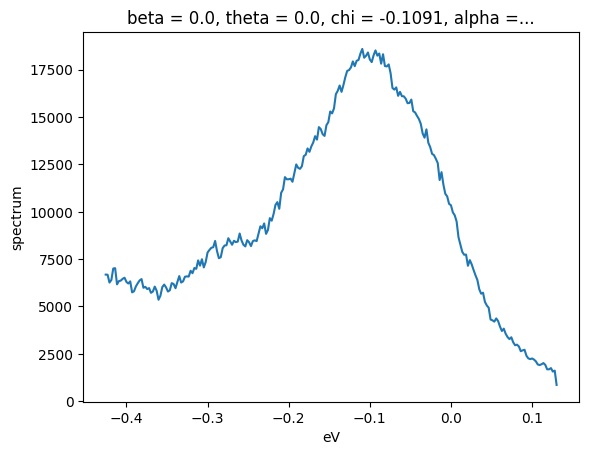

In [7]:
# get the EDC nearly at the gamma point
f.sel(phi=slice(0.38, 0.42)).sum("phi").S.plot()

### Selecting with array indices

In instances where you would like to subselect by an index (ranging above from 0 to 239), as opposed to the physically significant coordinate value, we can use `.isel` instead.

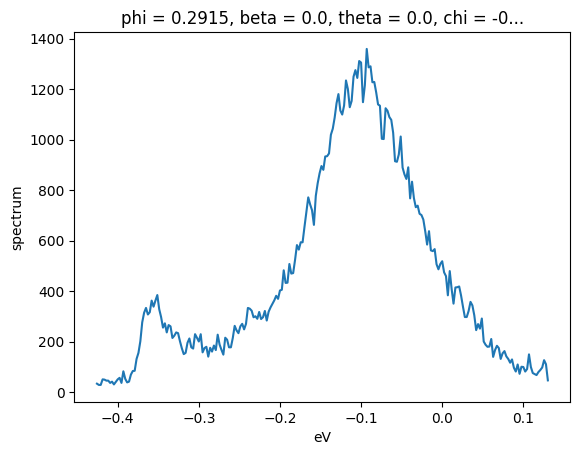

In [8]:
f.isel(phi=40).S.plot()

### Open ended selections

Selections can be made open ended on one or both sides by passing `None`. In the follow example, the inclusion of `None` will cause the selection to continue to the end of the data on the high end, i.e pixels 40 to 240 on the 'phi' axis.

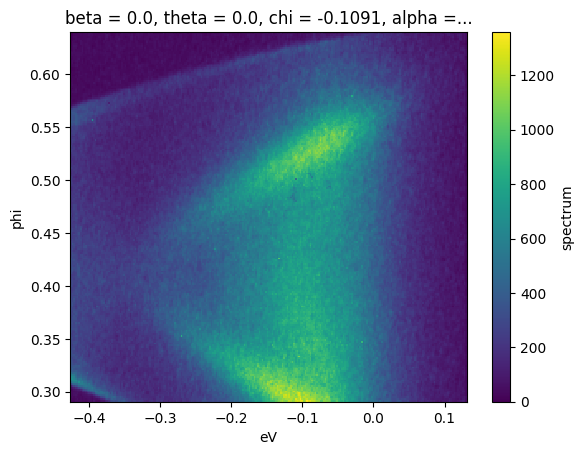

In [9]:
f.isel(phi=slice(40, None)).S.plot()

## Summing and Averaging

We saw above an example of taking a binned EDC by selecting a narrow angular region and taking the sum over that axis. We can also request means or sums over multiple axes with `.mean` and `.sum`.

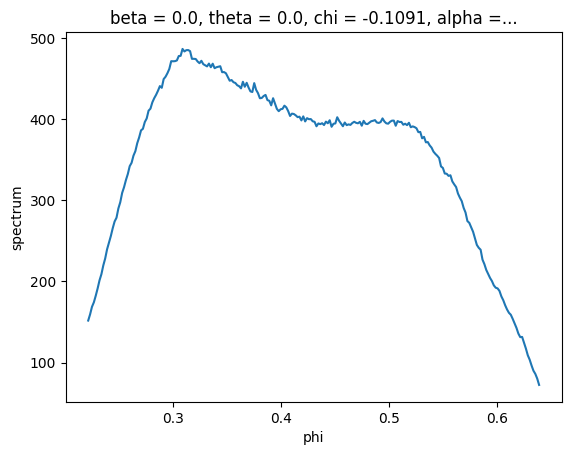

In [10]:
f.mean("eV").S.plot()

In [11]:
# to get the value as a plain float instead of a scalar dataset
# use `.mean(["eV", "phi"]).item()` instead
f.spectrum.mean(["eV", "phi"])

<xarray.DataArray 'spectrum' ()> Size: 8B
array(355.37399306)
Coordinates:
    beta     float64 8B 0.0
    theta    float64 8B 0.0
    chi      float64 8B -0.1091
    alpha    int64 8B 0
    hv       float64 8B 5.93
    z        float64 8B -3.4e-05
    x        float64 8B -0.7704
    psi      int64 8B 0
    y        float64 8B 34.75

**Caveat**: Summing an axis will remove all attributes unless the `keep_attrs=True` parameter is included in the call to `.sum`. Forgetting to do this where it is necessary can cause issues down the line for analysis that requires access to the attributes, such as in converting to momentum space, where the photon energy and coordinate offset for normal emission are stored as attributes.

## Transposing

To transpose axes, you can use `.transpose` or `.T`. In `xarray` and therefore in PyARPES, you interact with data using named dimensions. As a result, transposing is rarely necessary except to set axis order when plotting.

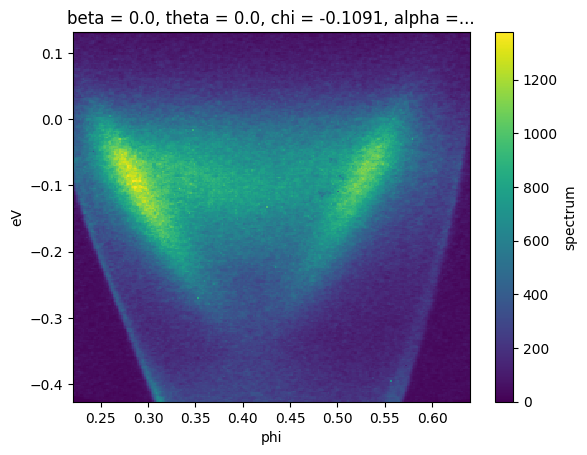

In [12]:
f.transpose("eV", "phi").S.plot()  # equivalently, f.T.S.plot()

## Interactive Data Browsing

Facilities are included for doing interactive data exploration and analysis both directly in Jupyter, via Bokeh. And in a separate standalone window using PyQt5. To learn more about interactive analysis, please read the interactive analysis section of the documentation.

In [13]:
from arpes.plotting.qt_tool import qt_tool

qt_tool(f)

/Users/arafune/src/arpes/src/arpes/plotting/qt_tool/__init__.py:541: UserWarning: You use Dataset as a argument of set_data in /Users/arafune/src/arpes/src/arpes/plotting/qt_tool/__init__.py
Remember to use a DataArray not a Dataset, attempting to extract spectrum and copy attributes.

  data_arr = data if isinstance(data, xr.DataArray) else normalize_to_spectrum(data)


![QtToolSummary.png](img/QtToolSummary.png)

### PyARPES philosophy on interactive tools

Instead of one large interactive application where you perform analysis, PyARPES has many small interactive utilities which are built for a single purpose. These include:

1. A data browser: `arpes.plotting.qt_tool.qt_tool`
2. A momentum offset browser: `arpes.plotting.qt_ktool.ktool`
3. A tool for path selection: `arpes.plotting.basic_tools.path_tool`
4. A tool for mask selection: `arpes.plotting.basic_tools.mask_tool`
5. A tool to show a slice on a BZ recorded by the spectrometer or scan: `arpes.plotting.bz_tool.bz_tool`

and others.

PyARPES prefers simpler specific tools because it makes them easier to write and maintain, and because PyARPES prefers you do as much analysis via the notebook as possible. This makes for better, more reproducible science.

## Learning more about data manipulation

PyARPES uses the excellent [xarray](https://xarray.pydata.org) to provide a rich "Wave"-like data model. For non-spectroscopy related
analysis tasks, you should read their documentation.

## Exercises

### Learning more about `xarray`

1. Skim the [data structures guide](https://xarray.pydata.org/en/stable/user-guide/data-structures.html) at the `xarray` docs.
2. Open a PyARPES Jupyter cell and print one of the piece of example data with `from arpes.io import example_data; example_data.cut` or similar. Make sure you can understand the correspondence between the [data structures guide](https://xarray.pydata.org/en/stable/user-guide/data-structures.html) and ARPES idioms.


### Practicing data selection

1. What happens if you select a range backward?
2. What happens to attributes and coordinates when you select a single value or range?

### Practicing interactive browsing
1. Try using `qt_tool` to find the projection of the gamma point in `example_data.map`? 
2. In `qt_tool`, press H to open the help panel and learn the cursor scrolling controls.

